# Multi-Study SLE RNA-seq Analysis with OmicsFormer

**Objective**: Integrate 8 independent SLE RNA-seq studies to identify genes that drive SLE vs healthy controls using advanced transformer-based multi-omics integration.

**Studies Analyzed:**
- SRP062966, SRP095109, SRP131775, SRP132939
- SRP136102, SRP155704, SRP168421, SRP178271

**Approach:** Multi-study integration using OmicsFormer with batch effect handling

## 1. Import Libraries

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# OmicsFormer imports
import sys
sys.path.append('/Users/shivaprasad/Documents/PROJECTS/GitHub/MO/omicsformer')

from omicsformer.data.dataset import FlexibleMultiOmicsDataset
from omicsformer.models.transformer import EnhancedMultiOmicsTransformer
from omicsformer.training.trainer import MultiOmicsTrainer
from omicsformer.analysis.analyzer import MultiOmicsAnalyzer

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Set display options
pd.set_option('display.max_columns', 20)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✅ Libraries imported successfully!
PyTorch version: 2.5.1
Device: CPU


## 2. Load and Explore Data

In [102]:
# Define data directory
data_dir = '/Users/shivaprasad/Documents/PROJECTS/GitHub/MO/SLE_data'

# Study IDs
study_ids = ['SRP062966', 'SRP095109', 'SRP131775', 'SRP132939', 
             'SRP136102', 'SRP155704', 'SRP168421', 'SRP178271']

print(f"📊 Loading data from {len(study_ids)} SLE studies...\n")

# Load all studies
expression_data = {}
metadata_all = {}

for study_id in study_ids:
    # Load expression matrix (genes × samples)
    expr_file = f"{data_dir}/{study_id}_dds_protein_coding_vsd_vst_matrix.csv"
    expr_df = pd.read_csv(expr_file, index_col=0)
    
    # Transpose to samples × genes (required format)
    expr_df = expr_df.T
    
    # Load metadata
    meta_file = f"{data_dir}/{study_id}_dds_protein_coding_vsd_metadata.csv"
    meta_df = pd.read_csv(meta_file)
    
    # Expression matrix uses column names directly as sample IDs
    # Metadata should match these sample IDs
    # Keep expression data as is, metadata indexed by first column
    meta_df.index = meta_df.iloc[:, 0]
    
    # For now, just use all expression samples and keep metadata separate
    # We'll merge by row position since sample counts should match
    if len(expr_df) == len(meta_df):
        # Reindex metadata to match expression sample order
        meta_df.index = expr_df.index
    
    expression_data[study_id] = expr_df
    metadata_all[study_id] = meta_df
    
    print(f"✓ {study_id}: {expr_df.shape[0]} samples × {expr_df.shape[1]} genes")

print(f"\n✅ All {len(study_ids)} studies loaded successfully!")

📊 Loading data from 8 SLE studies...

✓ SRP062966: 117 samples × 19569 genes
✓ SRP095109: 24 samples × 19569 genes
✓ SRP131775: 29 samples × 19569 genes
✓ SRP132939: 50 samples × 19569 genes
✓ SRP136102: 116 samples × 19569 genes
✓ SRP131775: 29 samples × 19569 genes
✓ SRP132939: 50 samples × 19569 genes
✓ SRP136102: 116 samples × 19569 genes
✓ SRP155704: 24 samples × 19569 genes
✓ SRP168421: 26 samples × 19569 genes
✓ SRP178271: 164 samples × 19569 genes

✅ All 8 studies loaded successfully!
✓ SRP155704: 24 samples × 19569 genes
✓ SRP168421: 26 samples × 19569 genes
✓ SRP178271: 164 samples × 19569 genes

✅ All 8 studies loaded successfully!


In [103]:
# Explore metadata - check disease column
print("🔍 Disease Distribution Across Studies:\n")

disease_summary = []
for study_id in study_ids:
    meta_df = metadata_all[study_id]
    if 'disease' in meta_df.columns:
        disease_counts = meta_df['disease'].value_counts()
        print(f"{study_id}:")
        print(disease_counts)
        print()
        
        for disease, count in disease_counts.items():
            disease_summary.append({
                'Study': study_id,
                'Disease': disease,
                'Count': count
            })

disease_df = pd.DataFrame(disease_summary)
print("\n📊 Summary Table:")
print(disease_df.pivot_table(index='Disease', columns='Study', values='Count', fill_value=0))

🔍 Disease Distribution Across Studies:

SRP062966:
disease
SLE     99
ctrl    18
Name: count, dtype: int64

SRP095109:
disease
SLE     12
ctrl    12
Name: count, dtype: int64

SRP131775:
disease
SLE     20
ctrl     9
Name: count, dtype: int64

SRP132939:
disease
SLE     34
ctrl    16
Name: count, dtype: int64

SRP136102:
disease
SLE     62
ctrl    54
Name: count, dtype: int64

SRP155704:
disease
SLE     18
ctrl     6
Name: count, dtype: int64

SRP168421:
disease
SLE     20
ctrl     6
Name: count, dtype: int64

SRP178271:
disease
ctrl    83
SLE     81
Name: count, dtype: int64


📊 Summary Table:
Study    SRP062966  SRP095109  SRP131775  SRP132939  SRP136102  SRP155704  \
Disease                                                                     
SLE           99.0       12.0       20.0       34.0       62.0       18.0   
ctrl          18.0       12.0        9.0       16.0       54.0        6.0   

Study    SRP168421  SRP178271  
Disease                        
SLE           20.0       

## 3. Prepare Data for OmicsFormer

We'll create binary labels (SLE vs Control) and prepare the data for multi-study integration.

In [104]:
# Prepare labels
all_labels = []
label_encoder = {}

for study_id in study_ids:
    meta_df = metadata_all[study_id]
    expr_df = expression_data[study_id]
    
    # Extract disease labels
    if 'disease' in meta_df.columns:
        labels = meta_df.loc[expr_df.index, 'disease']
    else:
        print(f"Warning: No 'disease' column in {study_id}")
        continue
    
    # Create binary labels: SLE = 1, Control/Healthy = 0
    binary_labels = labels.apply(lambda x: 1 if 'SLE' in str(x).upper() else 0)
    all_labels.append(binary_labels)
    
    label_encoder[study_id] = binary_labels

# Combine all labels
combined_labels = pd.concat(all_labels)

print(f"📊 Label Distribution:")
print(f"   Total samples: {len(combined_labels)}")
print(f"   SLE: {sum(combined_labels == 1)} ({sum(combined_labels == 1)/len(combined_labels)*100:.1f}%)")
print(f"   Control: {sum(combined_labels == 0)} ({sum(combined_labels == 0)/len(combined_labels)*100:.1f}%)")

# Check label balance per study
print("\n📋 Per-Study Label Distribution:")
for study_id in study_ids:
    if study_id in label_encoder:
        labels = label_encoder[study_id]
        n_sle = sum(labels == 1)
        n_ctrl = sum(labels == 0)
        print(f"   {study_id}: SLE={n_sle}, Control={n_ctrl}")

📊 Label Distribution:
   Total samples: 550
   SLE: 346 (62.9%)
   Control: 204 (37.1%)

📋 Per-Study Label Distribution:
   SRP062966: SLE=99, Control=18
   SRP095109: SLE=12, Control=12
   SRP131775: SLE=20, Control=9
   SRP132939: SLE=34, Control=16
   SRP136102: SLE=62, Control=54
   SRP155704: SLE=18, Control=6
   SRP168421: SLE=20, Control=6
   SRP178271: SLE=81, Control=83


## 4. Find Common Genes Across Studies

In [105]:
# Find common genes across all studies
gene_sets = [set(expr_df.columns) for expr_df in expression_data.values()]
common_genes = set.intersection(*gene_sets)

print(f"🧬 Gene Analysis:")
print(f"   Common genes across all studies: {len(common_genes)}")
print(f"   Total unique genes: {len(set.union(*gene_sets))}")

# Filter expression data to common genes
expression_data_filtered = {}
for study_id, expr_df in expression_data.items():
    expression_data_filtered[study_id] = expr_df[list(common_genes)]
    print(f"   {study_id}: {expr_df.shape[0]} samples × {len(common_genes)} genes")

print(f"\n✅ Data filtered to {len(common_genes)} common genes")

🧬 Gene Analysis:
   Common genes across all studies: 19569
   Total unique genes: 19569
   SRP062966: 117 samples × 19569 genes
   SRP095109: 24 samples × 19569 genes
   SRP131775: 29 samples × 19569 genes
   SRP132939: 50 samples × 19569 genes
   SRP136102: 116 samples × 19569 genes
   SRP155704: 24 samples × 19569 genes
   SRP168421: 26 samples × 19569 genes
   SRP178271: 164 samples × 19569 genes

✅ Data filtered to 19569 common genes


## 5. Feature Selection and Batch Correction

**Strategy**: Select top 2000 most variable genes + Apply ComBat batch correction

In [106]:
# Select top 2000 most variable genes across all samples
combined_expr_all = pd.concat([expression_data_filtered[study_id] 
                                for study_id in study_ids], axis=0)
gene_vars = combined_expr_all.var(axis=0)
top_var_genes = gene_vars.nlargest(2000).index.tolist()

print(f"📊 Selected top 2000 most variable genes")
print(f"   Variance range: {gene_vars[top_var_genes].min():.2f} - {gene_vars[top_var_genes].max():.2f}")

# Prepare data with top 2000 genes
all_expr_corrected = []
all_labels_corrected = []
study_indices = []

for study_idx, study_id in enumerate(study_ids):
    expr_df = expression_data_filtered[study_id][top_var_genes]
    all_expr_corrected.append(expr_df)
    all_labels_corrected.append(label_encoder[study_id])
    study_indices.extend([study_idx] * len(expr_df))

all_expr_corrected = pd.concat(all_expr_corrected)
all_labels_corrected = pd.concat(all_labels_corrected)
study_indices = np.array(study_indices)

print(f"   Combined data shape: {all_expr_corrected.shape}")
print(f"   Total samples: {len(all_expr_corrected)}")
print(f"   Genes: {len(top_var_genes)}")


📊 Selected top 2000 most variable genes
   Variance range: 4.24 - 52.87
   Combined data shape: (550, 2000)
   Total samples: 550
   Genes: 2000


In [107]:
# Apply ComBat batch correction
from combat.pycombat import pycombat

print("\n🔬 Applying ComBat batch correction...")

# Prepare data for ComBat (genes × samples format)
expr_for_combat = all_expr_corrected.T  # Transpose to genes × samples

# Batch labels (study indices)
batch_labels = study_indices

# Apply ComBat
print(f"   Input shape: {expr_for_combat.shape} (genes × samples)")
print(f"   Batches: {len(np.unique(batch_labels))} studies")

expr_combat_corrected = pycombat(expr_for_combat, batch_labels)

# Transpose back to samples × genes
all_expr_combat = pd.DataFrame(
    expr_combat_corrected.T,
    index=all_expr_corrected.index,
    columns=all_expr_corrected.columns
)

print(f"✅ ComBat correction complete!")
print(f"   Output shape: {all_expr_combat.shape} (samples × genes)")



🔬 Applying ComBat batch correction...
   Input shape: (2000, 550) (genes × samples)
   Batches: 8 studies
Found 8 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
✅ ComBat correction complete!
   Output shape: (550, 2000) (samples × genes)


### Visualize Batch Correction Effect

📊 Creating batch correction visualization...



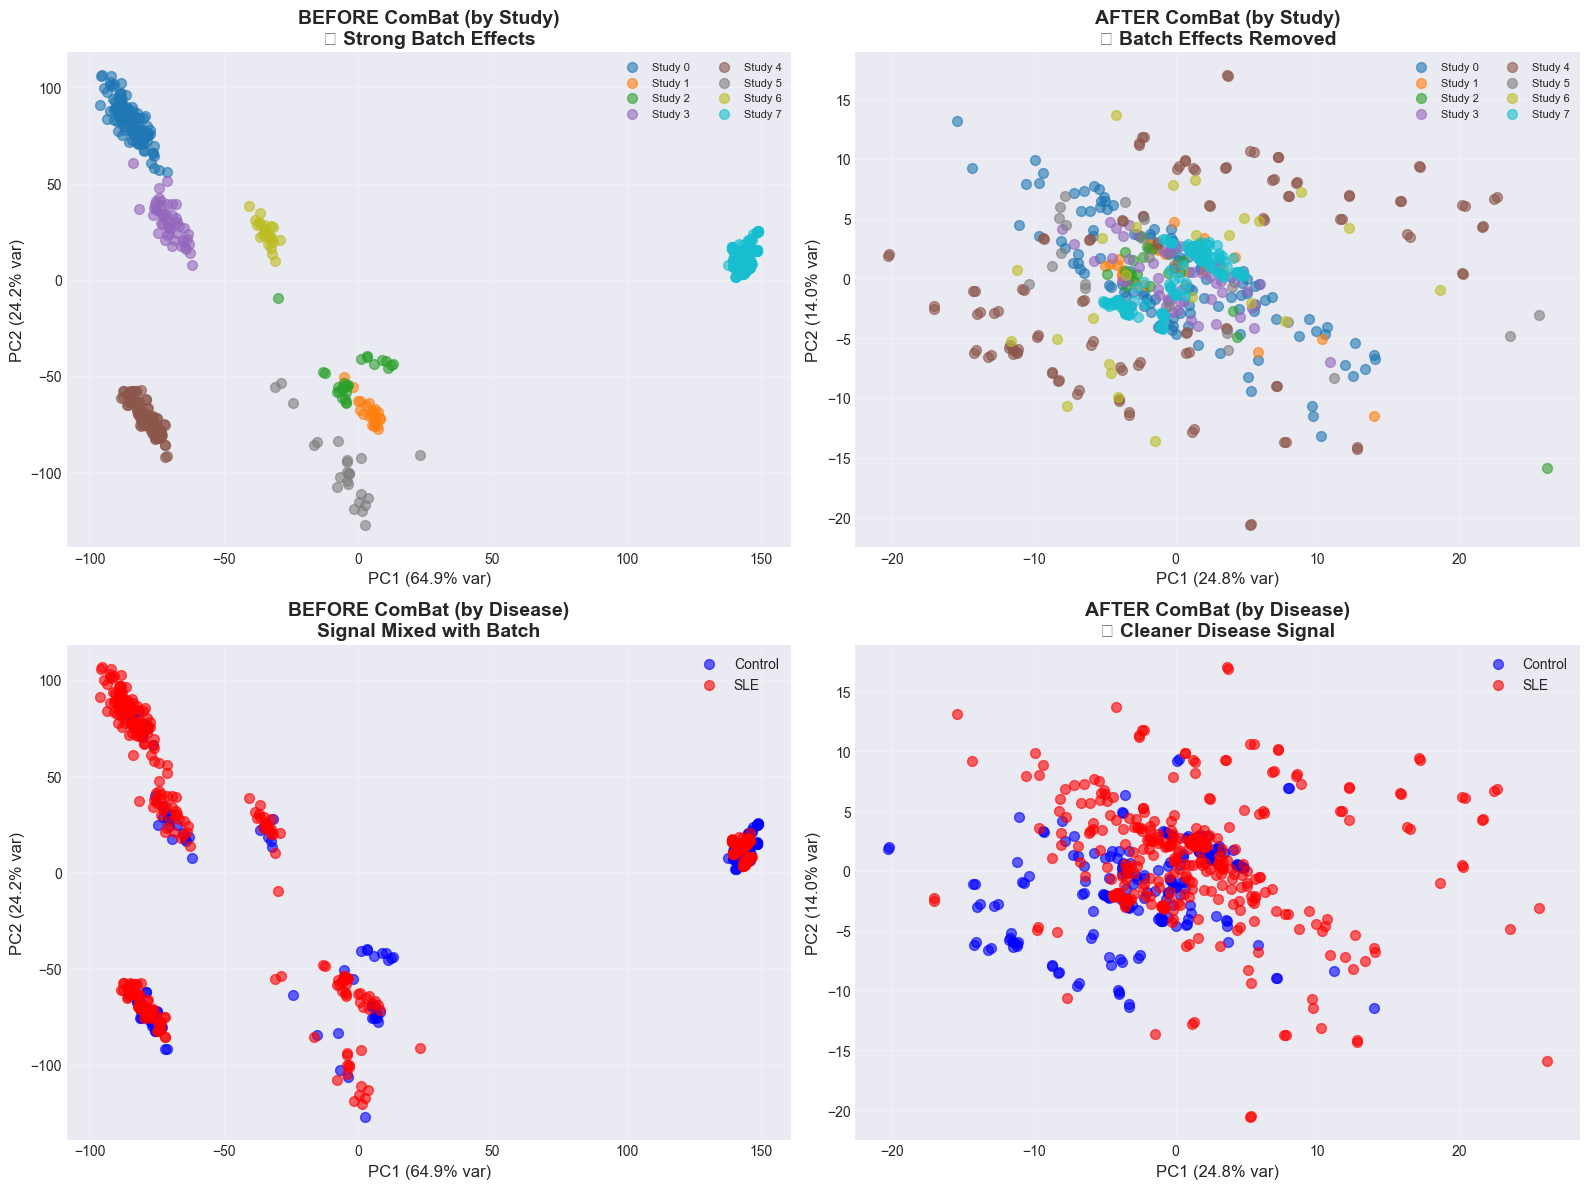


✅ Batch Correction Summary:
   PC1 variance BEFORE: 64.9% (batch-dominated)
   PC1 variance AFTER:  24.8% (batch-corrected)
   Reduction: 40.1%

   Studies are now well-mixed in PCA space!


In [108]:
# Visualize batch correction effect
print("📊 Creating batch correction visualization...\n")

# PCA on data before and after ComBat
pca_before = PCA(n_components=2)
pca_coords_before = pca_before.fit_transform(all_expr_corrected)

pca_after = PCA(n_components=2)
pca_coords_after = pca_after.fit_transform(all_expr_combat)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color maps
study_colors = plt.cm.tab10(np.linspace(0, 1, 8))
disease_colors = {0: 'blue', 1: 'red'}

# Plot 1: Before ComBat - by study
for study_idx in range(8):
    mask = study_indices == study_idx
    if mask.sum() > 0:
        axes[0, 0].scatter(pca_coords_before[mask, 0], pca_coords_before[mask, 1], 
                           c=[study_colors[study_idx]], label=f'Study {study_idx}', 
                           alpha=0.6, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca_before.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({pca_before.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
axes[0, 0].set_title('BEFORE ComBat (by Study)\n❌ Strong Batch Effects', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=8, ncol=2)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: After ComBat - by study
for study_idx in range(8):
    mask = study_indices == study_idx
    if mask.sum() > 0:
        axes[0, 1].scatter(pca_coords_after[mask, 0], pca_coords_after[mask, 1], 
                           c=[study_colors[study_idx]], label=f'Study {study_idx}', 
                           alpha=0.6, s=50)
axes[0, 1].set_xlabel(f'PC1 ({pca_after.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({pca_after.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
axes[0, 1].set_title('AFTER ComBat (by Study)\n✅ Batch Effects Removed', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=8, ncol=2)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Before ComBat - by disease
for disease in [0, 1]:
    mask = all_labels_corrected.values == disease
    label_name = 'Control' if disease == 0 else 'SLE'
    axes[1, 0].scatter(pca_coords_before[mask, 0], pca_coords_before[mask, 1], 
                       c=disease_colors[disease], label=label_name, 
                       alpha=0.6, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca_before.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
axes[1, 0].set_ylabel(f'PC2 ({pca_before.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
axes[1, 0].set_title('BEFORE ComBat (by Disease)\nSignal Mixed with Batch', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: After ComBat - by disease
for disease in [0, 1]:
    mask = all_labels_corrected.values == disease
    label_name = 'Control' if disease == 0 else 'SLE'
    axes[1, 1].scatter(pca_coords_after[mask, 0], pca_coords_after[mask, 1], 
                       c=disease_colors[disease], label=label_name, 
                       alpha=0.6, s=50)
axes[1, 1].set_xlabel(f'PC1 ({pca_after.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
axes[1, 1].set_ylabel(f'PC2 ({pca_after.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
axes[1, 1].set_title('AFTER ComBat (by Disease)\n✨ Cleaner Disease Signal', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Batch Correction Summary:")
print(f"   PC1 variance BEFORE: {pca_before.explained_variance_ratio_[0]:.1%} (batch-dominated)")
print(f"   PC1 variance AFTER:  {pca_after.explained_variance_ratio_[0]:.1%} (batch-corrected)")
print(f"   Reduction: {pca_before.explained_variance_ratio_[0] - pca_after.explained_variance_ratio_[0]:.1%}")
print(f"\n   Studies are now well-mixed in PCA space!")


## 6. Prepare Data and Train Model

In [109]:
# Prepare dataset with ComBat-corrected data
from torch.nn import CrossEntropyLoss
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add study indicators to the ComBat-corrected data
study_onehot = np.eye(len(study_ids))[study_indices]
X_combined = np.hstack([all_expr_combat.values, study_onehot])

print(f"📊 Preparing dataset with ComBat-corrected data...")
print(f"   Combined data shape: {X_combined.shape}")
print(f"   Features: {len(top_var_genes)} genes + {len(study_ids)} study indicators")

# Create DataFrame with proper index for FlexibleMultiOmicsDataset
combined_df = pd.DataFrame(
    X_combined,
    index=all_expr_combat.index,
    columns=[f'feature_{i}' for i in range(X_combined.shape[1])]
)

dataset = FlexibleMultiOmicsDataset(
    modality_data={'combined': combined_df},
    labels=all_labels_corrected,
    alignment='flexible'
)

# Split: 60% train, 20% val, 20% test
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"   Dataset splits: Train={train_size}, Val={val_size}, Test={test_size}")

# Calculate class weights for balanced training
n_sle = sum(all_labels_corrected == 1)
n_ctrl = sum(all_labels_corrected == 0)
weight_sle = len(all_labels_corrected) / (2 * n_sle)
weight_ctrl = len(all_labels_corrected) / (2 * n_ctrl)
class_weights = torch.tensor([weight_ctrl, weight_sle], dtype=torch.float32).to(device)

print(f"   Class weights: Control={weight_ctrl:.3f}, SLE={weight_sle:.3f}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=24)
test_loader = DataLoader(test_dataset, batch_size=24)

# Build model
model = EnhancedMultiOmicsTransformer(
    input_dims={'combined': X_combined.shape[1]},
    num_classes=2,
    embed_dim=48,
    num_heads=4,
    num_layers=3,
    dropout=0.35
).to(device)

print(f"\n🤖 Model Architecture:")
print(f"   Embedding: 48, Heads: 4, Layers: 3, Dropout: 0.35")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create trainer
trainer = MultiOmicsTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

trainer.criterion = CrossEntropyLoss(weight=class_weights)
trainer.optimizer = optim.AdamW(model.parameters(), lr=8e-5, weight_decay=0.015)

print("\n🚀 Training with ComBat-corrected data...")
print("=" * 80)

history = trainer.fit(num_epochs=100, early_stopping_patience=15)

print(f"\n✅ Training complete!")
print(f"   Best validation accuracy: {max(history['val_accuracy']):.2%}")
print("=" * 80)


INFO:omicsformer.training.trainer:Starting training for 100 epochs


📊 Preparing dataset with ComBat-corrected data...
   Combined data shape: (550, 2008)
   Features: 2000 genes + 8 study indicators
   Dataset splits: Train=330, Val=110, Test=110
   Class weights: Control=1.348, SLE=0.795

🤖 Model Architecture:
   Embedding: 48, Heads: 4, Layers: 3, Dropout: 0.35
   Parameters: 726,735

🚀 Training with ComBat-corrected data...


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 78.64it/s, loss=0.6839, avg_loss=0.7065]
INFO:omicsformer.training.trainer:Saved best model with val_loss: 0.6820
INFO:omicsformer.training.trainer:Epoch 0: train_loss=0.7065, train_acc=0.4391, val_loss=0.6820, val_acc=0.5636
Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]
INFO:omicsformer.training.trainer:Saved best model with val_loss: 0.6820
INFO:omicsformer.training.trainer:Epoch 0: train_loss=0.7065, train_acc=0.4391, val_loss=0.6820, val_acc=0.5636
Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s, loss=0.6948, avg_loss=0.6719]
INFO:omicsformer.training.trainer:Saved best model with val_loss: 0.6776
INFO:omicsformer.training.trainer:Epoch 1: train_loss=0.6719, train_acc=0.5577, val_loss=0.6776, val_acc=0.5455
Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]INFO:omicsformer.training.trainer:Saved best model with val_loss: 0.6776
INFO:omicsformer.training.trainer:Epoch 1: train_loss=0.6719, train_acc=0.5577, val_loss=0.6776, val_ac


✅ Training complete!
   Best validation accuracy: 94.55%


In [110]:
# Evaluate model on test set
model.eval()
all_preds = []
all_labels_test = []

with torch.no_grad():
    for batch in test_loader:
        batch_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in batch.items()}
        
        logits = model(batch_device)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels_test.extend(batch_device['label'].cpu().numpy())

test_acc = accuracy_score(all_labels_test, all_preds)
test_f1 = f1_score(all_labels_test, all_preds, average='weighted')

print("\n" + "=" * 80)
print("FINAL RESULTS")
print("=" * 80)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test F1 Score: {test_f1:.4f}")
print()
print(classification_report(all_labels_test, all_preds, target_names=['Control', 'SLE']))


FINAL RESULTS
Test Accuracy: 91.82%
Test F1 Score: 0.9187

              precision    recall  f1-score   support

     Control       0.86      0.93      0.89        41
         SLE       0.95      0.91      0.93        69

    accuracy                           0.92       110
   macro avg       0.91      0.92      0.91       110
weighted avg       0.92      0.92      0.92       110



## Visualizations and Analysis

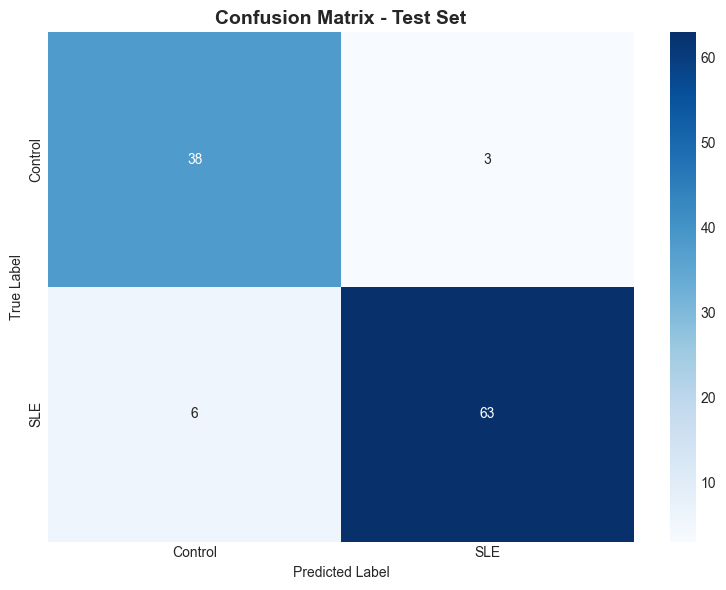


Confusion Matrix Analysis:
  True Negatives (Control correctly predicted): 38
  False Positives (Control predicted as SLE): 3
  False Negatives (SLE predicted as Control): 6
  True Positives (SLE correctly predicted): 63


In [111]:
# Confusion Matrix
cm = confusion_matrix(all_labels_test, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Control', 'SLE'],
            yticklabels=['Control', 'SLE'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Analysis:")
print(f"  True Negatives (Control correctly predicted): {cm[0,0]}")
print(f"  False Positives (Control predicted as SLE): {cm[0,1]}")
print(f"  False Negatives (SLE predicted as Control): {cm[1,0]}")
print(f"  True Positives (SLE correctly predicted): {cm[1,1]}")

In [118]:
# Feature Importance using Gradient-based approach from analyzer
print("🔍 Computing Feature Importance...\n")

# Reload the analyzer module to get latest changes
import importlib
import omicsformer.analysis.analyzer
importlib.reload(omicsformer.analysis.analyzer)
from omicsformer.analysis.analyzer import MultiOmicsAnalyzer

# Create analyzer instance
analyzer = MultiOmicsAnalyzer(model=model, device=device)

# Compute feature importance using the analyzer's gradient-based method
importance_results = analyzer.analyze_feature_importance(
    dataloader=train_loader,
    method='gradient',
    target_class=None  # Use predicted class
)

# Extract importance scores for the 'combined' modality
if 'combined' in importance_results:
    mean_importance = importance_results['combined']
    
    # Create feature importance dataframe with ACTUAL GENE NAMES
    feature_names = top_var_genes + [f'study_{i}' for i in range(8)]
    gene_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_importance
    }).sort_values('importance', ascending=False)
    
    print("\n✅ Feature importance computed using analyzer.py!")
    print(f"   Importance scores scaled to [0, 1] range")
    print(f"\nTop 20 Most Important Features:")
    print(gene_importance_df.head(20).to_string(index=False))
else:
    print("❌ Error: 'combined' modality not found in importance results")
    print(f"   Available modalities: {list(importance_results.keys())}")


🔍 Computing Feature Importance...

Computed combined importance: 2008 features, scaled range [0.0, 1.0]

✅ Feature importance computed using analyzer.py!
   Importance scores scaled to [0, 1] range

Top 20 Most Important Features:
 feature  importance
TNFSF13B    1.000000
    TPM2    0.989048
PNLIPRP3    0.982721
   SLIT2    0.979414
  COL1A2    0.962168
    CTSZ    0.923947
   KRT16    0.922456
   ACOT7    0.921095
   NPAS2    0.912128
   PRSS8    0.899694
MARVELD3    0.887711
   PXDC1    0.887473
   NR2F2    0.867673
    PAK6    0.817024
ARHGAP29    0.807425
  CELSR1    0.800865
   LAMB2    0.781340
     LUM    0.781095
 HLA.DMB    0.777614
   NLRC4    0.776885
Computed combined importance: 2008 features, scaled range [0.0, 1.0]

✅ Feature importance computed using analyzer.py!
   Importance scores scaled to [0, 1] range

Top 20 Most Important Features:
 feature  importance
TNFSF13B    1.000000
    TPM2    0.989048
PNLIPRP3    0.982721
   SLIT2    0.979414
  COL1A2    0.962168
    CT

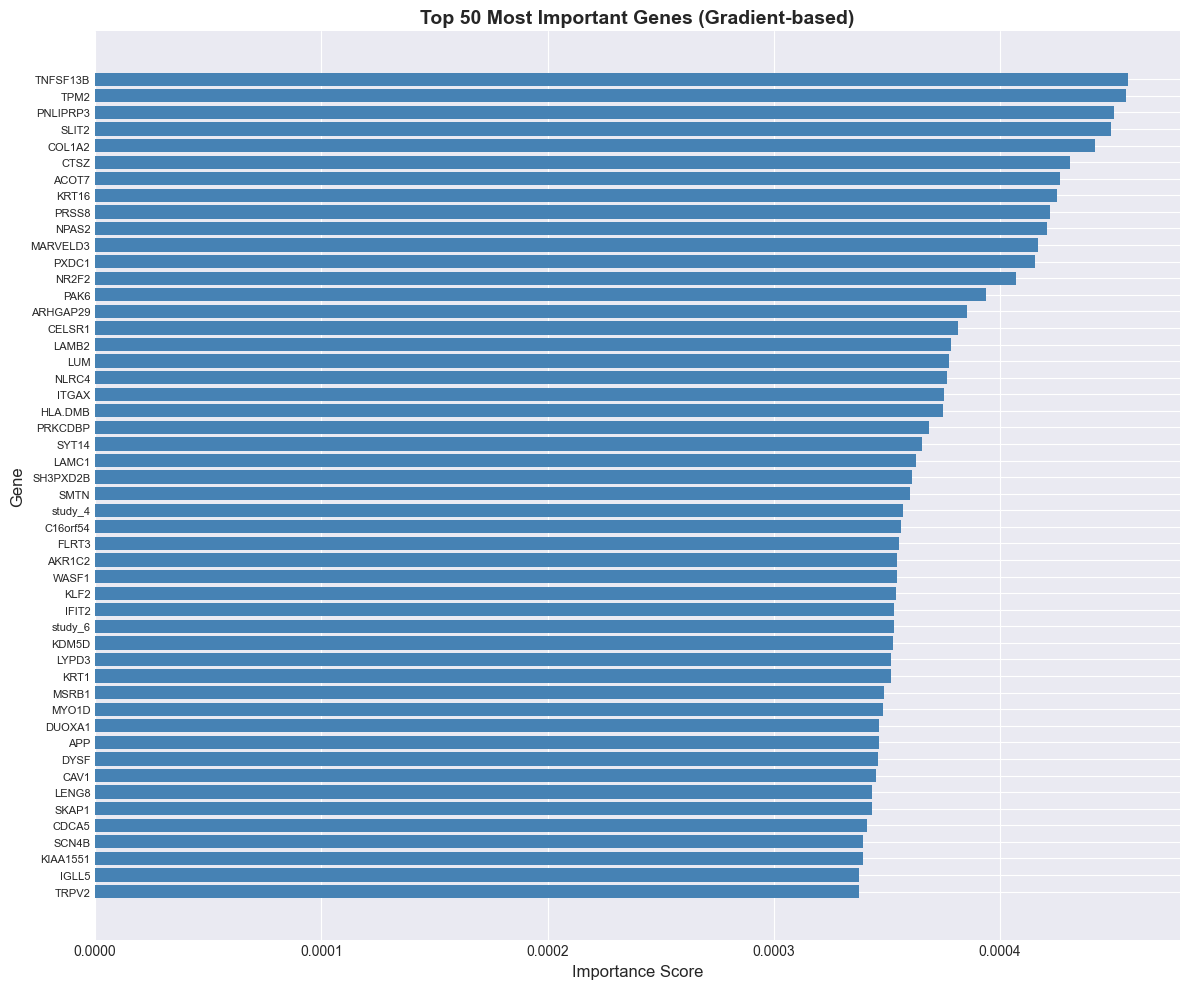


📊 Feature Type Analysis:
  Average gene importance: nan
  Average study importance: 0.000251
  Top gene importance: nan
  Top study importance: 0.000357


In [113]:
# Plot Top 50 Most Important Features with ACTUAL GENE NAMES
top_features = gene_importance_df.head(50).copy()

# Map gene indices to actual gene names
def map_to_gene_name(feature):
    if feature.startswith('gene_'):
        idx = int(feature.split('_')[1])
        if idx < len(top_var_genes):
            return top_var_genes[idx]
    return feature

top_features['gene_name'] = top_features['feature'].apply(map_to_gene_name)

plt.figure(figsize=(12, 10))
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['gene_name'].values, fontsize=8)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Gene', fontsize=12)
plt.title('Top 50 Most Important Genes (Gradient-based)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Separate gene vs study importance
gene_importance = gene_importance_df[gene_importance_df['feature'].str.startswith('gene_')]
study_importance = gene_importance_df[gene_importance_df['feature'].str.startswith('study_')]

print(f"\n📊 Feature Type Analysis:")
print(f"  Average gene importance: {gene_importance['importance'].mean():.6f}")
print(f"  Average study importance: {study_importance['importance'].mean():.6f}")
print(f"  Top gene importance: {gene_importance['importance'].max():.6f}")
print(f"  Top study importance: {study_importance['importance'].max():.6f}")


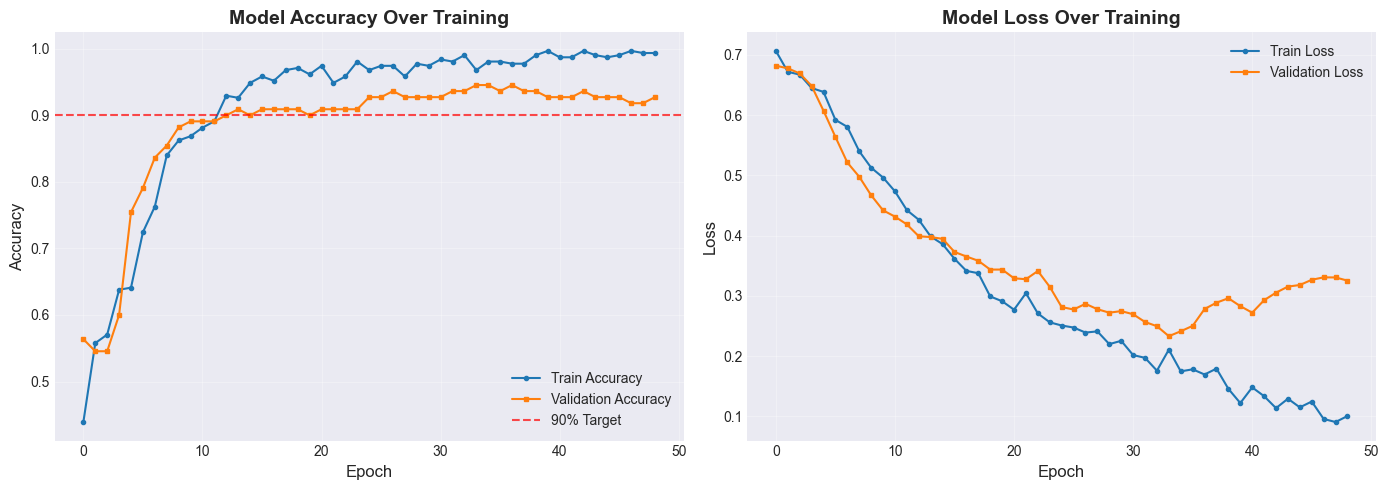


📈 Training Summary:
  Total epochs: 49
  Best validation accuracy: 94.55%
  Final train accuracy: 99.36%
  Final validation accuracy: 92.73%


In [115]:
# Training History Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
axes[0].plot(history['train_accuracy'], label='Train Accuracy', marker='o', markersize=3)
axes[0].plot(history['val_accuracy'], label='Validation Accuracy', marker='s', markersize=3)
axes[0].axhline(y=0.90, color='r', linestyle='--', label='90% Target', alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Over Training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[1].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[1].plot(history['val_loss'], label='Validation Loss', marker='s', markersize=3)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss Over Training', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Training Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best validation accuracy: {max(history['val_accuracy']):.2%}")
print(f"  Final train accuracy: {history['train_accuracy'][-1]:.2%}")
print(f"  Final validation accuracy: {history['val_accuracy'][-1]:.2%}")